# Persistent Train Data

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
from df_helpers import non_persistent_preprocessing, persistent_preprocessing

df_persistent = TabularDataset('Training.csv')

df_persistent.replace([np.inf, -np.inf], np.nan, inplace=True) 
df_persistent.dropna(inplace=True) 

df_persistent = df_persistent.sample(frac=1, random_state=29)

for attack_type in list(df_persistent['Label'].unique()):
    if attack_type == 'NormalTraffic':
        df_persistent.loc[df_persistent['Label'] == attack_type, ['Label']] = 'benign'
    else:
        df_persistent.loc[df_persistent['Label'] == attack_type, ['Label']] = 'persistent'

df_only_persistent_threats = df_persistent.loc[df_persistent['Label'] == 'persistent'].copy(deep=True)

df_only_persistent_threats = persistent_preprocessing(df_only_persistent_threats)

# Non-Persistent Train Data

In [2]:
non_persistent_file_names = ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 
           'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
           'Friday-WorkingHours-Morning.pcap_ISCX.csv',
           'Monday-WorkingHours.pcap_ISCX.csv',
           'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
           'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
           'Tuesday-WorkingHours.pcap_ISCX.csv',
           'Wednesday-workingHours.pcap_ISCX.csv'
]

df_non_persistent = pd.DataFrame()

for file in non_persistent_file_names:
    print(file)
    df_temp = TabularDataset('non-persistent/'+file)
    df_temp.replace([np.inf, -np.inf], np.nan, inplace=True) 
    df_temp.dropna(inplace=True)
    df_non_persistent = pd.concat([df_temp, df_non_persistent])

df_non_persistent = non_persistent_preprocessing(df_non_persistent)


Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Wednesday-workingHours.pcap_ISCX.csv


<Axes: >

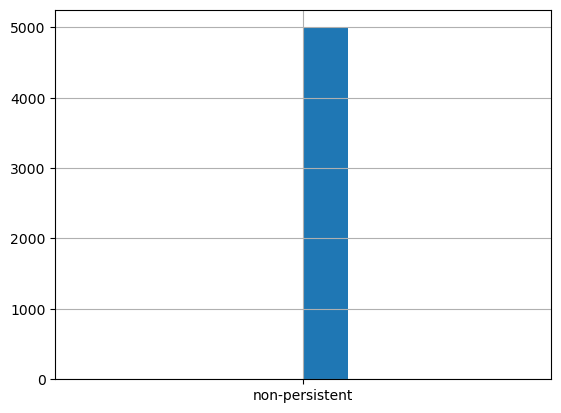

In [3]:
list(df_non_persistent['Label'].unique())

for attack_type in list(df_non_persistent['Label'].unique()):
    if attack_type == 'BENIGN':
        df_non_persistent.loc[df_non_persistent['Label'] == attack_type, ['Label']] = 'benign'
    else:
        df_non_persistent.loc[df_non_persistent['Label'] == attack_type, ['Label']] = 'non-persistent'


df_only_non_persistent_threats = df_non_persistent.loc[df_non_persistent['Label'] == 'non-persistent'][:5000].copy(deep=True)

df_only_non_persistent_threats['Label'].hist()

# Create combined train set

In [4]:
combined_training_df = pd.concat([df_only_persistent_threats, df_only_non_persistent_threats])

# drop column names that aren't shared
common_columns = list(set(df_only_persistent_threats).intersection(df_only_non_persistent_threats))


for column_name in combined_training_df:
    if column_name not in common_columns:
        print(f'Dropped column: {column_name}')
        combined_training_df.drop([column_name], axis=1, inplace=True)

<Axes: >

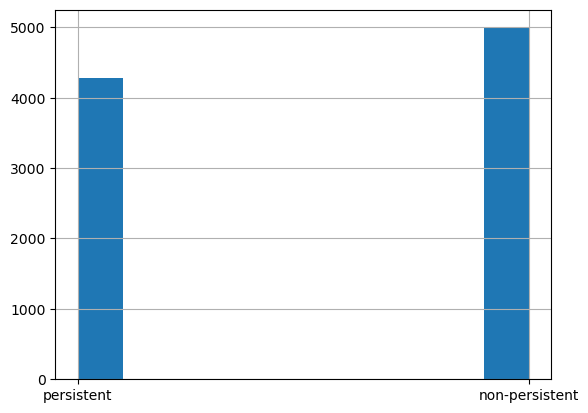

In [5]:
combined_training_df['Label'].hist()

# Persistent Test dataset

<Axes: >

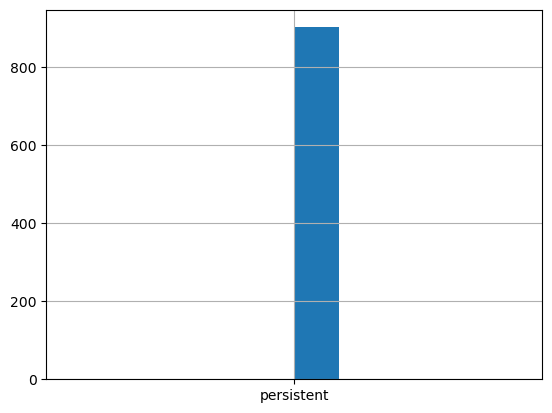

In [6]:
# test/train split
df_persistent_test = TabularDataset('Testing.csv')

df_persistent_test.replace([np.inf, -np.inf], np.nan, inplace=True) 
df_persistent_test.dropna(inplace=True) 

df_persistent_test = df_persistent_test.sample(frac=1, random_state=29)

for attack_type in list(df_persistent_test['Label'].unique()):
    if attack_type == 'NormalTraffic':
        df_persistent_test.loc[df_persistent_test['Label'] == attack_type, ['Label']] = 'benign'
    else:
        df_persistent_test.loc[df_persistent_test['Label'] == attack_type, ['Label']] = 'persistent'

df_only_persistent_threats_test = df_persistent_test.loc[df_persistent_test['Label'] == 'persistent'].copy(deep=True)

df_only_persistent_threats_test = persistent_preprocessing(df_only_persistent_threats_test)

df_only_persistent_threats_test['Label'].hist()

# Non-Persistent Test Dataset

<Axes: >

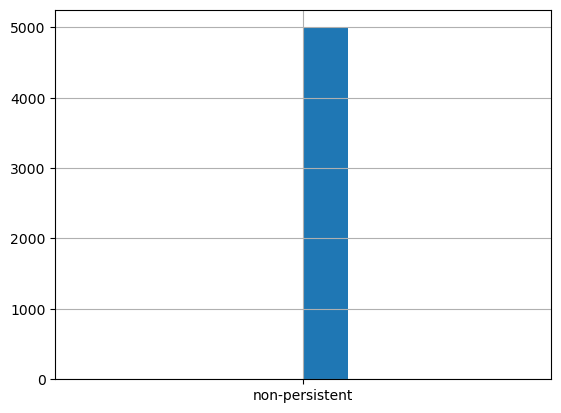

In [7]:
# Grab last 5000
df_only_non_persistent_threats_test = df_non_persistent.loc[df_non_persistent['Label'] == 'non-persistent'][-5000:]

df_only_non_persistent_threats_test['Label'].hist()

# Combined Testing Dataset

In [8]:
combined_testing_df = pd.concat([df_only_persistent_threats_test, df_only_non_persistent_threats_test])

<Axes: >

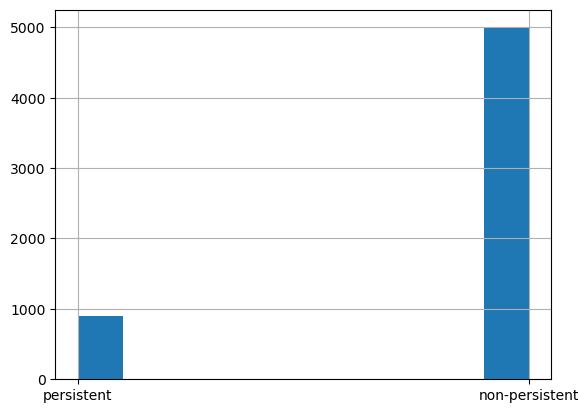

In [9]:
combined_testing_df['Label'].hist()

# Check that Training and Test set columns are matching

In [10]:
bool(set(list(combined_training_df)).intersection(set(list(combined_testing_df))))

True

# Train Model with Autogluon

In [11]:
predictor = TabularPredictor(label='Label', eval_metric='mcc').fit(combined_training_df, fit_weighted_ensemble = False, presets = 'medium')

No path specified. Models will be saved in: "AutogluonModels/ag-20250409_075243"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.8
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:22:58 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8132
CPU Count:          10
Memory Avail:       3.11 GB / 16.00 GB (19.4%)
Disk Space Avail:   277.97 GB / 460.43 GB (60.4%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "/Users/navya/Documents/Uni/Repos/autogluon/AutogluonModels/ag-20250409_075243"
Train Data Rows:    9283
Train Data Columns: 78
Label Column:       Label
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['persistent', 'non-persistent']
	If 'binary' is not th

In [12]:
predictor.leaderboard(combined_testing_df)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,1.000000,1.0,mcc,0.001612,0.001243,0.548230,0.001612,0.001243,0.548230,1,True,4
1,LightGBMLarge,1.000000,1.0,mcc,0.001934,0.001080,0.705715,0.001934,0.001080,0.705715,1,True,13
2,LightGBMXT,1.000000,1.0,mcc,0.002425,0.001173,1.461372,0.002425,0.001173,1.461372,1,True,3
3,XGBoost,1.000000,1.0,mcc,0.012500,0.002644,0.389645,0.012500,0.002644,0.389645,1,True,11
4,CatBoost,1.000000,1.0,mcc,0.014998,0.003423,29.243445,0.014998,0.003423,29.243445,1,True,7
5,RandomForestEntr,1.000000,1.0,mcc,0.029413,0.014397,0.269384,0.029413,0.014397,0.269384,1,True,6
6,RandomForestGini,1.000000,1.0,mcc,0.030168,0.027386,0.308693,0.030168,0.027386,0.308693,1,True,5
7,ExtraTreesEntr,1.000000,1.0,mcc,0.030959,0.027212,0.211204,0.030959,0.027212,0.211204,1,True,9
8,ExtraTreesGini,1.000000,1.0,mcc,0.031405,0.024900,0.239194,0.031405,0.024900,0.239194,1,True,8
9,KNeighborsDist,1.000000,1.0,mcc,0.050444,0.011343,0.008956,0.050444,0.011343,0.008956,1,True,2


# Testing

In [13]:
y_pred = predictor.predict(combined_testing_df.drop(columns=['Label']))
y_pred.head()

0    persistent
1    persistent
2    persistent
3    persistent
4    persistent
Name: Label, dtype: object

In [14]:
predictor.evaluate(combined_testing_df)


{'mcc': 1.0,
 'accuracy': 1.0,
 'balanced_accuracy': 1.0,
 'roc_auc': 1.0,
 'f1': 1.0,
 'precision': 1.0,
 'recall': 1.0}

# Model Export Binary Persistent/Non-persistent

In [15]:
save_path_clone_opt = "persistent-non-persistent-classifier"
# will return the path to the cloned predictor, identical to save_path_clone_opt
path_clone_opt = predictor.clone_for_deployment(path=save_path_clone_opt)

Cloned TabularPredictor located in '/Users/navya/Documents/Uni/Repos/autogluon/AutogluonModels/ag-20250409_075243' to 'persistent-non-persistent-classifier'.
	To load the cloned predictor: predictor_clone = TabularPredictor.load(path="persistent-non-persistent-classifier")
Clone: Keeping minimum set of models required to predict with best model 'LightGBMLarge'...
Deleting model KNeighborsUnif. All files under /Users/navya/Documents/Uni/Repos/autogluon/persistent-non-persistent-classifier/models/KNeighborsUnif will be removed.
Deleting model KNeighborsDist. All files under /Users/navya/Documents/Uni/Repos/autogluon/persistent-non-persistent-classifier/models/KNeighborsDist will be removed.
Deleting model LightGBMXT. All files under /Users/navya/Documents/Uni/Repos/autogluon/persistent-non-persistent-classifier/models/LightGBMXT will be removed.
Deleting model LightGBM. All files under /Users/navya/Documents/Uni/Repos/autogluon/persistent-non-persistent-classifier/models/LightGBM will be